Скачайте с сайта datamarket.com наиболее понравившийся вам датасет и далее работайте с ним.

Разбейте данные на train и test (test - последние 15%-30% данных в зависимости от размера датасета).

1) Постройте адаптивные модели двойного экспоненциального сглаживания и тройного экспоненциального сглаживания. 
Сделайте предсказания и измерьте ошибки mse и mae на train и test.

2*) Исследуйте данные на стационарность. Проверьте наличие сезонных эффектов, зависимостей от предыдущих значений ряда, сбалансируйте дисперсию с помощью преобразования Бокса-Кокса. Приведите ряд к стационарному и примените к полученному стационарному ряду модель ARMA. Подберите оптимальные параметры p и q для ARMA с помощью минимизации AIC.

3) Постройте предсказание с помощью модели ARIMA (или SARIMA, если вы подозреваете наличие сезонных эффектов в данных). Измерьте ошибки предсказаний на train и test.

4) Сделайте предсказание с помощью fbprophet и измерьте mse и mae предсказания на train и на test

5) Поработайте над созданием новых признаков (лаги, аггрегированные признаки и т.д.) и примените для предсказания линейную регрессию и какой-нибудь нелинейный алгоритм.

6) Сравните результаты всех полученных алгоритмов. Какой алгоритм дал наилучшее качество? Какой алгоритм имеет самое маленькое время настройки параметров при хорошем качестве?

7*) Попробуйте скомбинировать наилучшие модели. Улучшилось ли качество предсказания?

Задания 2 и 7 опциональные.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import minimize
import statsmodels
import statsmodels.api as sm
import datetime
import warnings
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore")


%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('monthly-total-number-of-pigs-sla.csv', index_col = ['Month'])

In [3]:
data.info()

#уберем пропущенные значения

data = data.dropna()

<class 'pandas.core.frame.DataFrame'>
Index: 189 entries, 1980-01 to Monthly total number of pigs slaughtered in Victoria. Jan 1980 ? August 1995
Data columns (total 1 columns):
Monthly total number of pigs slaughtered in Victoria. Jan 1980 ? August 1995    188 non-null float64
dtypes: float64(1)
memory usage: 3.0+ KB


In [4]:
data.columns = ['Total']

In [5]:
# преобразуем тип индекса Dataframe в datetime
data.index = [datetime.datetime.strptime(i,"%Y-%m") for i in data.index] 


In [6]:
# поскольку количество дней каждого месяца не единое число, выведем среднее значение
# убитых свиней  по каждому месяцу

import calendar

month = [i.month for i in data.index]
year = [i.year for i in data.index]     
data['month'] = month
data['year'] = year

i = 0

# создаем список количетсва дней в месяце года
day_in_month = []                   
while i < data.shape[0]:
    day_in_month.append(calendar.monthrange(data['year'][i], data['month'][i])[1])
    i = i+1

data['day_in_month'] = day_in_month

# создаем отнормированное значение целевой переменной 
data['aver_total'] = data['Total']/data['day_in_month']
del data['Total']
del data['day_in_month']


Разбейте данные на train и test (test - последние 15%-30% данных в зависимости от размера датасета).

In [7]:
train_index = int(data.shape[0]*0.7)  
data_for_train = data.iloc[:train_index,:]   #датасет для обучения
data_for_test = data.iloc[train_index:,:]    #датасет для тестирования

In [8]:
from sklearn.model_selection import TimeSeriesSplit

def TimeSerCV (data, n_splits,test_size):
    
    """
    Фунция делит временной ряд на n_splits фолдов  в равных долях и затем
    каждый фолд разбивает на обучающую и тестовую выборку.
    
    Результаты разбиение на train, test помещаются в список folds таким образом,
    что сохраняется очередность фолдов и test фолда всегда идет непосредсвенно 
    перед его train-ом.
    """
    
    
    tss = TimeSeriesSplit(n_splits=n_splits)
    index = [len(i[0]) for i in tss.split(data)]
    index.append(len(data)-1)
    index = index[1:]
    folds = []
    for i in index:
        train = data[:int(i*(1-0.3))]
        test = data[int(i*(1-0.3)):i+1]
        folds.extend((train,test))

    return folds    

Первичный анализ ряда:

Критерий Дики-Фулера  = 0.2539656035935819


<Figure size 432x288 with 0 Axes>

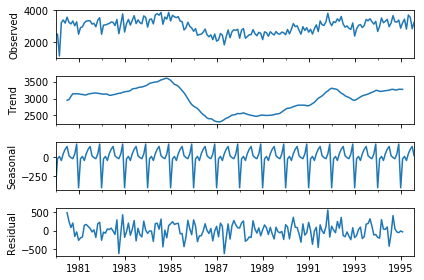

In [9]:
plt.figure()
sm.tsa.seasonal_decompose(data['aver_total']).plot()
print(f'Критерий Дики-Фулера  = {sm.tsa.stattools.adfuller(data.aver_total)[1]}')

Ряд обладает сложным нелинейным трендом и месячной сезонностью, следовательно для его предстказания
мы можем использовать модели двойного и тройного экспоненциального сглаживания

In [10]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [11]:
%%time
# разбиваем ряд на фолды кросс-валидации
folds = TimeSerCV(data_for_train['aver_total'],3,0.3)

#задаем дадафрейм, в котором будем собирать качество каждой модели в зависмости от значений
#гиперпараметров
sm_results = pd.DataFrame()
fold = []
alph= []
bet = []
MAE = []
MSE = []
helper = []       # костыль для удобной сортировки
i = 0
while i <len(folds):
    for alpha in np.linspace(0.1,1,10):
        for beta in  np.linspace(0.1,1,10):
            model = double_exponential_smoothing(folds[i], alpha, beta)
            
            index = len(folds[i])+1
            actual = data['aver_total'][:index]
            MAE_test = mean_absolute_error(actual,model)
            MSE_test = mean_squared_error(actual,model)
            fold.append(i)
            alph.append(alpha)
            bet.append(beta)
            MAE.append(MAE_test)
            MSE.append(MSE_test)
            helper.append(str(alpha) +" " +str(beta))
    
    i = i+2       
sm_results['fold'] = fold
sm_results['alpha'] = alph
sm_results['beta'] = bet
sm_results['MAE'] = MAE
sm_results['MSE'] = MSE
sm_results['model'] = helper           

Wall time: 698 ms


In [12]:
# получаем наилучшее значение параметров 
m = sm_results.groupby('model').agg('mean').sort_values('MSE') 
alpha_best = m.iloc

In [13]:
alpha_best = m.iloc[0,1]
beta_best = m.iloc[0,2]
print(f'Наименьшее значение MSE модели получено при Alpha = {alpha_best}, beta ={beta_best}')


Наименьшее значение MSE модели получено при Alpha = 0.9, beta =0.10000000000000002


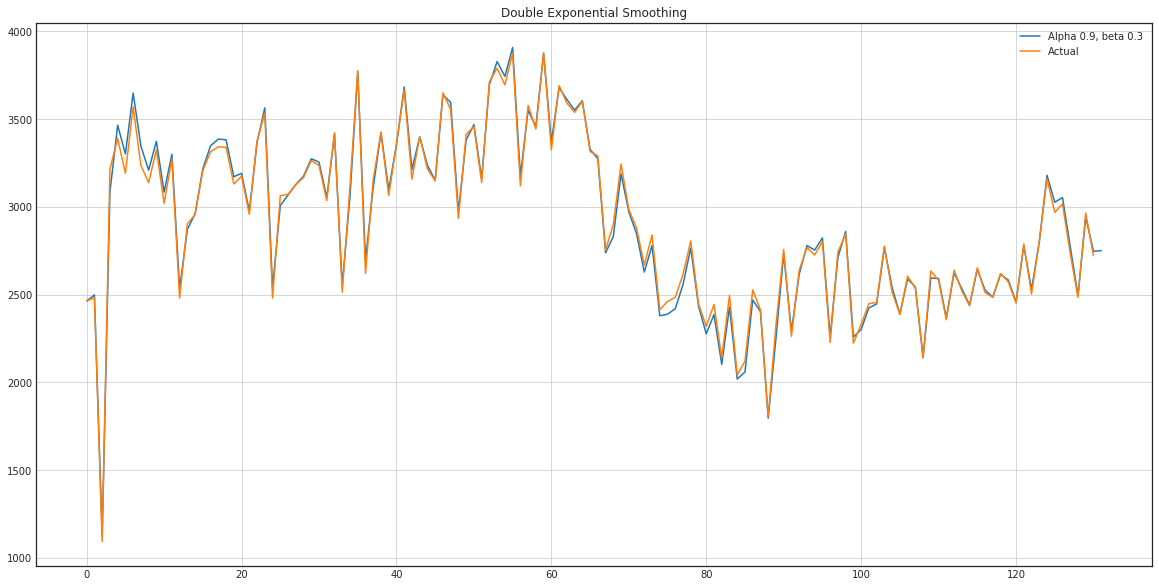

In [14]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 10))
    plt.plot(double_exponential_smoothing(data_for_train.aver_total, alpha_best, beta_best),
             label="Alpha {}, beta {}".format(0.9, 0.3))
            
    plt.plot(data_for_train.aver_total.values, label = "Actual")
    plt.legend(loc="best")
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

По графику предсказанное значение довольно близко к действительному отклику. Поскольку методом двойного экспоненциального
сглаживания можно предсказывать значения только на очень ограниченный период времени и метод двойного экспоненционального сглаживания не учитывает наличие сезонности, прогнозирование на длительный отложенный период становится неэффективным.

Покажем это на тестовой выборке


In [15]:
def double_exponential_smoothing_pred(series, pred_period, alpha, beta):
    
    """
    
    Функция двойного экспоненциального сглаживания, 
    строящая прогноз на заданный горизонт прогноза
    pred_period
    
       
    """
    result = [series[0]]
    for n in range(1, len(series)+pred_period):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

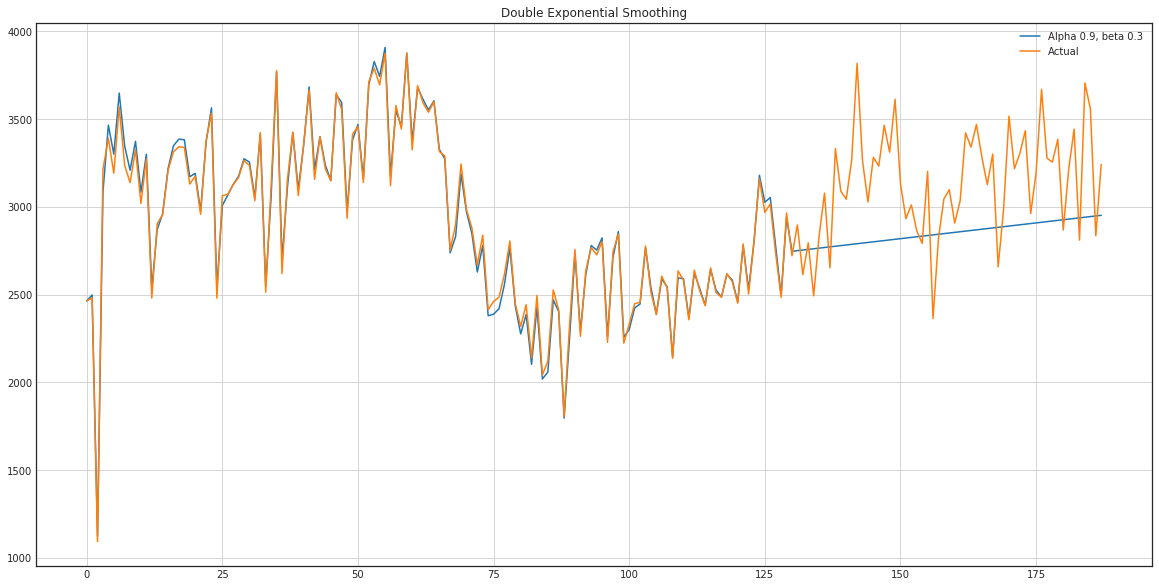

In [16]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 10))
    pre_period = data_for_test.aver_total
    plt.plot(double_exponential_smoothing_pred(data_for_train.aver_total, len(pre_period), alpha_best, beta_best),
             label="Alpha {}, beta {}".format(0.9, 0.3))
            
    plt.plot(data.aver_total.values, label = "Actual")
    plt.legend(loc="best")
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

In [17]:
# Ошибка на обучающей выборке
predict_train = double_exponential_smoothing_pred(data_for_train['aver_total'],0, alpha_best, beta_best)
MAE_train = round(mean_absolute_error(data_for_train.aver_total, predict_train),2)
MSE_train = round(mean_squared_error(data_for_train.aver_total, predict_train),2)
print("Качество модели двойного экспоненциального сглаживания:")
print(f'Величина ошибка на обучающей части ряда: MAE = {MAE_train}, MSE = {MSE_train}')

predict_test = double_exponential_smoothing_pred(data_for_train['aver_total'],len(data_for_test.aver_total), 
                                                 alpha_best, beta_best)
MAE_test = round(mean_absolute_error(data_for_test.aver_total, predict_test[len(data_for_train):]),2)
MSE_test = round(mean_squared_error(data_for_test.aver_total, predict_test[len(data_for_train):]),2)
print(f'Величина ошибка на тестовой части ряда: MAE = {MAE_test}, MSE = {MSE_test}')


Качество модели двойного экспоненциального сглаживания:
Величина ошибка на обучающей части ряда: MAE = 29.96, MSE = 1493.47
Величина ошибка на тестовой части ряда: MAE = 341.37, MSE = 166365.8


Как видно, модель, дающая хорошее предстказание на тесте, дает плохое предсказание на тестовой части длительного периода.
Модель подходит только для краткосрочного прогноза.

In [18]:
 #Создадим DataFrame для оценки результатов методов:
total = pd.DataFrame()
alg = []                    #название метода
AE_test = []                 
SE_test = []
AE_train = []
SE_train = []
t = []                   #wall time

alg.append('double_exponential_smoothing')
AE_train.append(MAE_train)
SE_train.append(MSE_train)
AE_test.append(MAE_test)
SE_test.append(MSE_test)
t.append('704 ms')

**Построение прогноза Тройного Экспоненциального сглаживания**

In [19]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])



In [20]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data_for_train.aver_total.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 12, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

In [21]:
%%time

# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)


0.6400566820361409 0.03718959454170889 0.5314703384424897
Wall time: 1.69 s


In [22]:
model = HoltWinters(series=data_for_train.aver_total, slen = 12, alpha=alpha_final, beta=beta_final,
                    gamma=gamma_final,n_preds=len(data_for_test.aver_total))
model.triple_exponential_smoothing()
prediction = model.result[-57:]
actual = data_for_test.aver_total

MSE_train = round(mean_squared_error(data_for_train.aver_total, model.result[:-57]),2)
MAE_train = round(mean_absolute_error(data_for_train.aver_total, model.result[:-57]),2)

MSE_test = round(mean_squared_error(actual,prediction),2)
MAE_test = round(mean_absolute_error(actual,prediction),2)
print(f'Величина ошибки на обучающей части ряда:MAE = {MAE_train}, MSE = {MSE_train}')
print(f'Величина ошибки на тестовой части ряда:MAE = {MAE_test}, MSE = {MSE_test}')

Величина ошибки на обучающей части ряда:MAE = 41.42, MSE = 3085.28
Величина ошибки на тестовой части ряда:MAE = 351.97, MSE = 181571.0


In [23]:
# заполняем списки результатов

alg.append('triple_exponential_smoothing')
AE_train.append(MAE_train)
SE_train.append(MSE_train)
AE_test.append(MAE_test)
SE_test.append(MSE_test)
t.append('1.64 s')

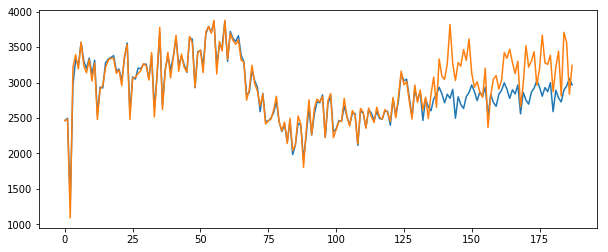

In [24]:
plt.figure(figsize(10,4))
plt.plot(model.result, label = "Model")
plt.plot(data.aver_total.values, label = "Actual")


***ВЫВОД***:
    По сравнению с двойным экспоненциальным сглаживанием, модель тройного экспоненциального сглаживания уже 
    немного предсказывает характер дальнейшего поведения ряда, однако не успевает подстроиться под меняющий
    свое направление тренд.
    Ошибка становится немного выше по сравнению с двойным сглаживанием.

***2*) Исследуйте данные на стационарность. Проверьте наличие сезонных эффектов, зависимостей от предыдущих значений ряда, сбалансируйте дисперсию с помощью преобразования Бокса-Кокса. Приведите ряд к стационарному и примените к полученному стационарному ряду модель ARMA. Подберите оптимальные параметры p и q для ARMA с помощью минимизации AIC***

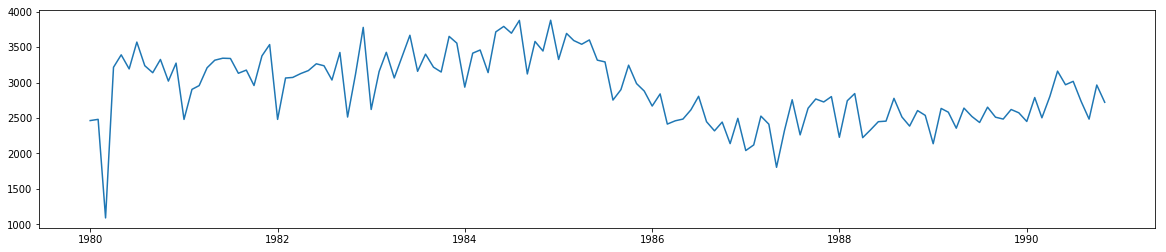

In [25]:
plt.figure(figsize=(20,4))
plt.plot(data_for_train['aver_total'])

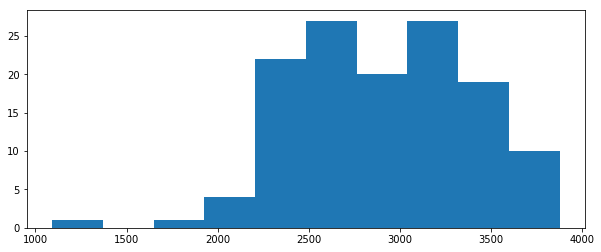

In [26]:
rng = np.random.RandomState(10)  # deterministic random data
a = np.hstack((rng.normal(size=1000),rng.normal(loc=5, scale=2, size=1000)))
plt.hist(data_for_train['aver_total'], bins='auto')  # arguments are passed to np.histogr
plt.show()


На первый взгляд, временной ряд имеет нелинейный, меняющие направление, тренд. 
Данные ряда в начале 1980 года (ферваль- март), на мой взгляд, не являются закономемерными для данного ряда и скорее
всего говорят о каких-то производственных проблемах отрасли в этот период времени.

Ряд имеет нестабильную дисперсию.

Рассмотрим составляющие ряда более подробно на декомпозиции ряда:

In [27]:
data.describe()

,month,year,aver_total
count,188.000000,188.000000,188.000000
mean,6.414894,1987.340426,2978.035406
std,3.443694,4.537551,448.711701
min,1.000000,1980.000000,1092.677419
25%,3.000000,1983.000000,2631.183180
50%,6.000000,1987.000000,3031.532258
75%,9.000000,1991.000000,3301.362903
max,12.000000,1995.000000,3876.903226


Критерий Дики-Фулера  = 0.551990197997978


<Figure size 720x288 with 0 Axes>

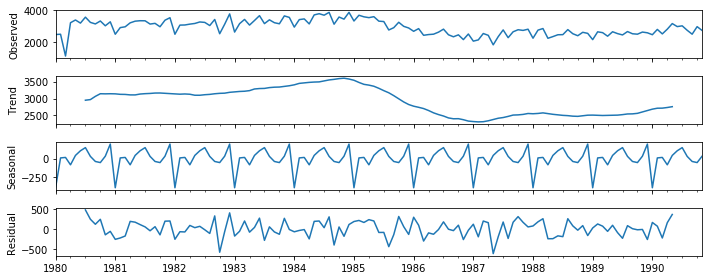

In [28]:
plt.figure(figsize(10,4))
sm.tsa.seasonal_decompose(data_for_train['aver_total']).plot()
print(f'Критерий Дики-Фулера  = {sm.tsa.stattools.adfuller(data_for_train.aver_total)[1]}')
      

Проведенная декомпозиция ряда свидетельсвует о наличии нелинейного тренда.Можно сделать предположение, что 
есть некоторый цикл, который после достижения наивысшео пика, спустя 2-3 года после окончания значений данного ряда,
приведет к снижению показателей (появится участок убывающего тренда.

Декомпозиция также выделает сезонность (12 месяцев) с минимальным значением в начале года.

Шумы  похожи на белый шум (однако, при желании, мы может проверить стационарность шума)


Значение критерия Дики-Фулера существенно выше порогового значения, следовательно, ряд - нестационарен.

Оптимальное значение lmbda = 1.4705886847402705
Критерий Дики-Фулера  = 0.5521062609940854


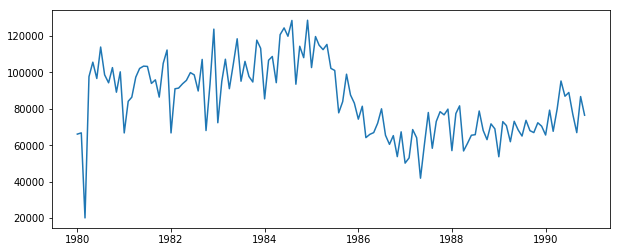

In [29]:
# применяем преобразование Бокса-Кокса для стабилизации дисперсии ряда
data_for_train['aver_total_box'], lmbda = stats.boxcox(data_for_train['aver_total'])
plt.plot(data_for_train['aver_total_box'])

print(f'Оптимальное значение lmbda = {lmbda}')
print(f'Критерий Дики-Фулера  = {sm.tsa.stattools.adfuller(data_for_train.aver_total_box)[1]}')
del data_for_train['aver_total_box']
                

Как вижно из нового значения p-value  критерия Дики-фулера, преобразование Бокса-Кокса не сделало ряд болле стационарным.
Не будет учитывать в далнейшем даннок=е преобразование.

Посмотрим на графики автокорреляции и частичной автокорреляции

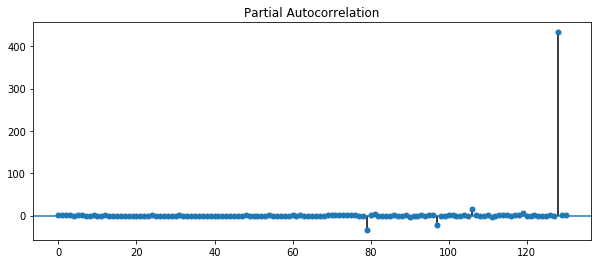

<Figure size 720x288 with 0 Axes>

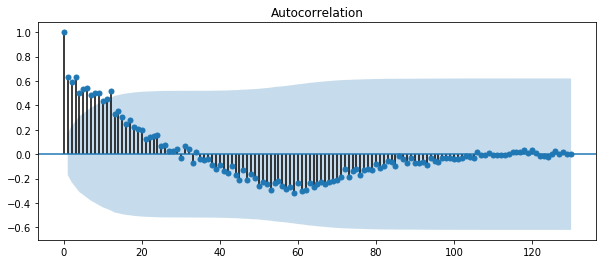

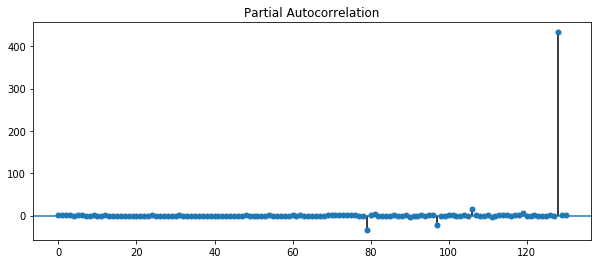

In [30]:
plt.figure(figsize(10,4))
sm.graphics.tsa.plot_acf(data_for_train.aver_total)
sm.graphics.tsa.plot_pacf(data_for_train.aver_total)

График автокорреляции указывает на наличилие сильной зависимости значений от предыдущих значений.
Наглядно заметно наличие цикличности. 
Частная автокорреляция находит лишь несколько коррелированных значений ряда.


Поскольку рассматриваемый ряд нестационарен, и мы наглядно увидели наличие годовой сезонности, для достижения
стационарности ряда выполним сезонное дифференцирование.

Значение критерия Дики-Фулера для ряда с сезонным дифференцированием =      0.03685259722999953
единичных корней нет, ряд стационарен


<Figure size 720x288 with 0 Axes>

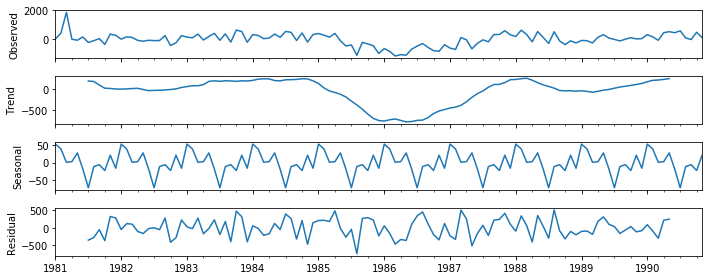

In [31]:
data_for_train['aver_total_diff12'] = data_for_train['aver_total'].diff(12)
data_for_train = data_for_train.dropna()
plt.figure(figsize(10,4))
sm.tsa.seasonal_decompose(data_for_train.aver_total_diff12).plot()
print(f'Значение критерия Дики-Фулера для ряда с сезонным дифференцированием = \
     {sm.tsa.stattools.adfuller(data_for_train.aver_total_diff12)[1]}')
if sm.tsa.stattools.adfuller(data_for_train.aver_total_diff12)[0]> \
sm.tsa.stattools.adfuller(data_for_train.aver_total_diff12)[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

Как можно заметить на графике сезонное дифференцирование существенно скорректировало ряд,
значение критерия Дики_фулера снизилось в два раза.Ряд стал стационарным.

Поскольку рассматриваемых ряд стал стационарным, применим к его данным модель ARMA.
Найдем первоначальное приближение параметров модели.

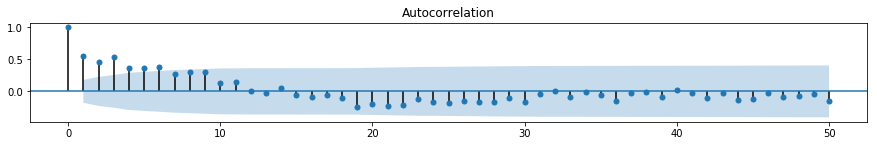

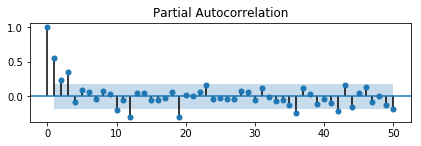

In [32]:
plt.figure(figsize(15,4))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_for_train.aver_total_diff12.values.squeeze(), lags = 50, ax = ax)
pylab.show()

ax1 = plt.subplot(222)
sm.graphics.tsa.plot_pacf(data_for_train.aver_total_diff12.values.squeeze(), lags = 50, ax = ax1)
pylab.show()

In [33]:
p = range(0,4) #подбираю по частичной автокоррелияции
q = range(0,7) #подбираю по автокорреляции (вероятная граница [0,4], но проверю и малые корреляции)

In [34]:
# создаю возможные комбинации значений параметров
from itertools import product

param = list(product(p,q))
print(param)

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6)]


In [35]:
%%time
result = []
best_aic = float("inf")

for it in param:
    try:
        model = sm.tsa.ARMA(data_for_train.aver_total_diff12, order = (it[0],it[1])).fit()
    except ValueError:
        print(f'wrong parameters:{it}')
        continue    
    aic = model.aic 
    # сохраняю лучшую модель
    if aic < best_aic:
        best_model  = model
        best_aic = aic
        best_param  = it
    result.append([it, model.aic])    
result

wrong parameters:(1, 5)
wrong parameters:(2, 5)
wrong parameters:(2, 6)
wrong parameters:(3, 5)
wrong parameters:(3, 6)
Wall time: 6.41 s


In [36]:
best_param

(3, 1)

In [37]:
ARMA_model = sm.tsa.ARMA(data_for_train.aver_total_diff12, order = (best_param[0],best_param[1])).fit()

In [38]:
ARMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:      aver_total_diff12   No. Observations:                  119
Model:                     ARMA(3, 1)   Log Likelihood                -858.269
Method:                       css-mle   S.D. of innovations            326.473
Date:                Fri, 22 Mar 2019   AIC                           1728.537
Time:                        22:48:47   BIC                           1745.212
Sample:                    01-01-1981   HQIC                          1735.308
                         - 11-01-1990                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      24.2133    134.241      0.180      0.857    -238.894     287.320
ar.L1.aver_total_diff12     0.0345      0.172      0.200      0.842      -0.303       0.372
ar.L2.aver_total_diff12     0.1811      0.108      1.673      0.097      -0.031       0.393
ar.L3.aver_total_diff12     0.5043      0.093      5.434      0.000       0.322       0.686
ma.L1.aver_total_diff12     0.3147      0.189      1.669      0.098      -0.055       0.684
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1309           -0.0000j            1.1309           -0.0000
AR.2           -0.7450           -1.0947j            1.3242           -0.3451
AR.3           -0.7450           +1.0947j            1.3242            0.3451
MA.1           -3.1772           +0.0000j            3.1772            0.5000
-----------------------------------------------------------------------------
"""

Коэффициенты модели значимы.

Посмотрим на остатки модели, чтобы оценить ее качество: значение критерия Дики-Фулера для остатков временного ряда 
указывает на его стационарность, однако график автокорреляции находит все-таки наличие автокоррелированных значений
(9 лаг, которым можно пренебречь).

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).


Критерий Стьюдента: p=0.834589
Критерий Дики-Фуллера: p=0.000000


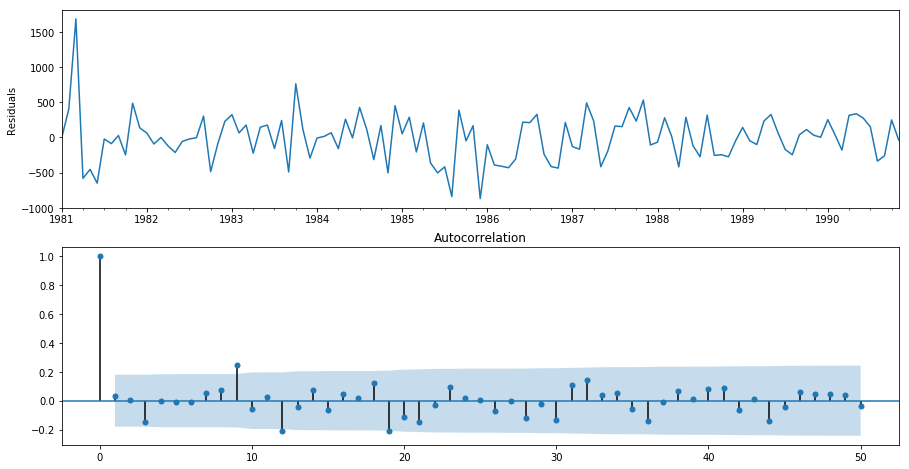

In [39]:
plt.figure(figsize(15,8))
plt.subplot(211)
ARMA_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(ARMA_model.resid.values.squeeze(), lags=50, ax=ax)
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(ARMA_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(ARMA_model.resid)[1])



Посмотрим, как наша модель угадывает временной ряд:

Значение ошибки модели ARMA на обучающем ts: MAE = 251.7,MSE = 112015.23


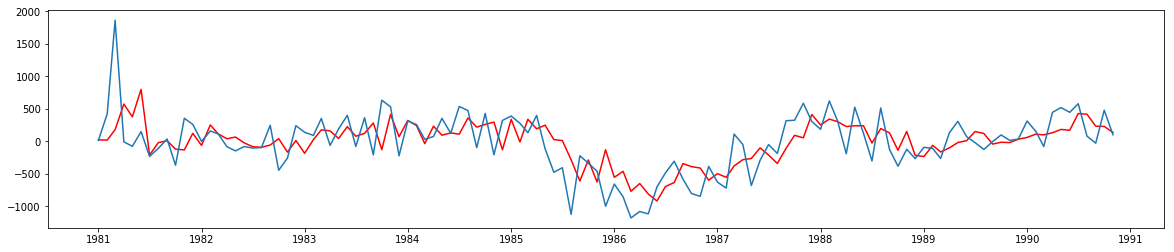

In [40]:
data_for_train['ARMA_model'] = ARMA_model.fittedvalues
plt.figure(figsize(20,4))
plt.plot(data_for_train['ARMA_model'], label = 'ARMA',color = 'r')
plt.plot(data_for_train.aver_total_diff12, label = 'actual')

MSE_ARMA_train = round(mean_squared_error(data_for_train.aver_total_diff12,data_for_train.ARMA_model),2)
MAE_ARMA_train = round(mean_absolute_error(data_for_train.aver_total_diff12,data_for_train.ARMA_model),2)

print(f'Значение ошибки модели ARMA на обучающем ts: MAE = {MAE_ARMA_train},MSE = {MSE_ARMA_train}')

In [41]:
date_list = [datetime.datetime.strptime("1990-12-01", "%Y-%m-%d") + relativedelta(months=x) \
             for x in range(0,len(data_for_test.aver_total))]
actual = data_for_test.aver_total.values
data['forecast_ARMA'] = best_model.predict(start=1, end=188)
data['forecast'] = data['forecast_ARMA'] + data.aver_total.shift(12)

MAE_test_ARMA = round(mean_absolute_error(actual,data['forecast'][-57:].values),2)
MSE_test_ARMA = round(mean_squared_error(actual,data['forecast'][-57:].values),2)
print(f'Ошибка прогноза модели ARMA на тестовой части ряда: MAE = {round(MAE_test_ARMA,2)}, MSE = {round(MSE_test_ARMA,2)}')


Ошибка прогноза модели ARMA на тестовой части ряда: MAE = 316.49, MSE = 154618.97


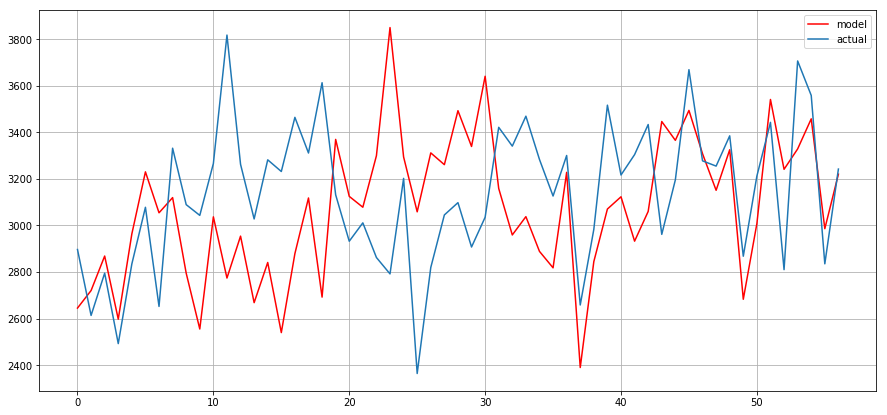

In [42]:
plt.figure(figsize=(15, 7))
plt.plot(data['forecast'][-57:].values, color='r', label="model")
plt.plot(actual, label="actual")
plt.legend()
#plt.axvspan(len(actual), len(data['forecast_ARIMA']), alpha=0.5, color='lightgrey')
plt.grid(True)


График не совсем точно угадывет ряд, давая достаточно высокую ошибку даже на обучающей части ряда.
(Прогноз  дает похожие результаты).

In [43]:
alg.append('ARMA')
AE_train.append(MAE_ARMA_train)
SE_train.append(MSE_ARMA_train)
AE_test.append(MAE_test_ARMA)
SE_test.append(MSE_test_ARMA)
t.append('6.51 s')

***3) Постройте предсказание с помощью модели ARIMA (или SARIMA, если вы подозреваете наличие сезонных эффектов в данных). Измерьте ошибки предсказаний на train и test.***

Ранее уже было выяснено, что ряд нестационарен, имеет тренд и выраженную годовую сезонность.
Кроме того, также было показано, что для рассматриваемого ряда нецелесообразно применение преобразования
Бокса-Кокса.
Для вычисления начальных приближений параметров модели обратимся с графикам автокорреляции, построенным в 
начале предыдущей модели.

q = 9
Q = 1
p = 3
P = 1
d = 0
D =1

In [44]:
q = range(0,10)         
Q = range(0,2)
p = range(0,4)
P = range(0,2)
d = range(0,1)
D = range(0,2)

In [45]:
param = list(product(p,d,q,P,D,Q))

Для построения модели SARIMA в качестве исходных данным берем стационарный ряд - предсказания будут более точными.

In [46]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for p in param:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        
        model=sm.tsa.statespace.SARIMAX(data_for_train.aver_total_diff12, order=(p[0], p[1], p[2]),
                                        seasonal_order=(p[3], p[4], p[5], 14)).fit(disp=False)
        
        
            #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        #print('wrong parameters:', p)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = p
    results.append([p, model.aic])
    
warnings.filterwarnings('default')


Wall time: 5min 15s


In [47]:
results = pd.DataFrame(results, columns=['model','AIC'])
print(results.sort_values(by = 'AIC', ascending=True))

                  model          AIC
259  (3, 0, 3, 0, 1, 1)  1551.405036
243  (3, 0, 1, 0, 1, 1)  1552.244552
247  (3, 0, 1, 1, 1, 1)  1552.312892
235  (3, 0, 0, 0, 1, 1)  1552.566032
239  (3, 0, 0, 1, 1, 1)  1552.757622
227  (2, 0, 9, 0, 1, 1)  1552.791431
73   (0, 0, 9, 0, 1, 1)  1552.843217
151  (1, 0, 9, 0, 1, 1)  1553.123091
255  (3, 0, 2, 1, 1, 1)  1553.250555
251  (3, 0, 2, 0, 1, 1)  1553.629667
263  (3, 0, 3, 1, 1, 1)  1553.891245
75   (0, 0, 9, 1, 1, 1)  1554.102470
195  (2, 0, 5, 0, 1, 1)  1554.463545
199  (2, 0, 5, 1, 1, 1)  1554.601071
267  (3, 0, 4, 0, 1, 1)  1554.620993
231  (2, 0, 9, 1, 1, 1)  1554.974949
155  (1, 0, 9, 1, 1, 1)  1555.356164
131  (1, 0, 6, 1, 1, 1)  1555.724665
111  (1, 0, 4, 0, 1, 1)  1555.811926
119  (1, 0, 5, 0, 1, 1)  1555.914167
115  (1, 0, 4, 1, 1, 1)  1555.915669
123  (1, 0, 5, 1, 1, 1)  1556.018273
271  (3, 0, 4, 1, 1, 1)  1556.089567
127  (1, 0, 6, 0, 1, 1)  1556.491447
183  (2, 0, 3, 1, 1, 1)  1556.653059
139  (1, 0, 7, 1, 1, 1)  1556.776404
2

In [48]:
best_model

In [49]:
# 1495,93 (3,0,2,1,1)
best_aic

1551.4050360640736

Критерий Дики-Фуллера: p=0.000000
единичных корней нет, ряд стационарен


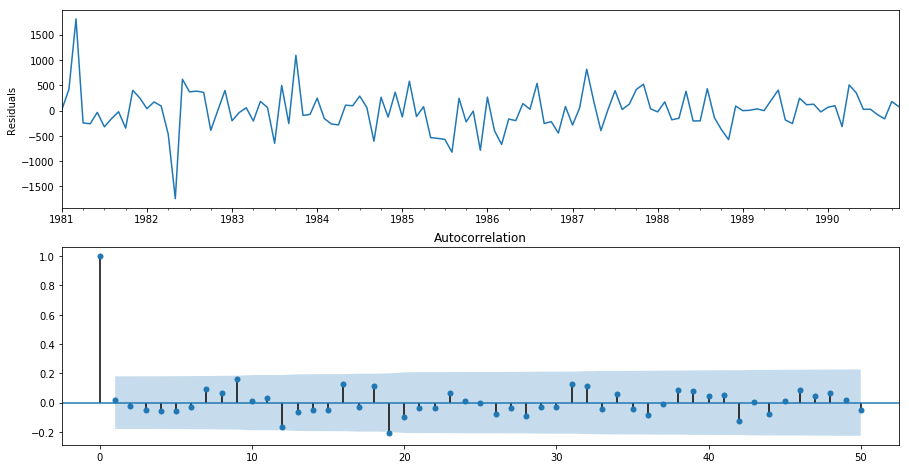

In [50]:
# Оценим остатки лучшей модели

plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=50, ax=ax)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])
if sm.tsa.stattools.adfuller(best_model.resid)[0]> \
sm.tsa.stattools.adfuller(best_model.resid)[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

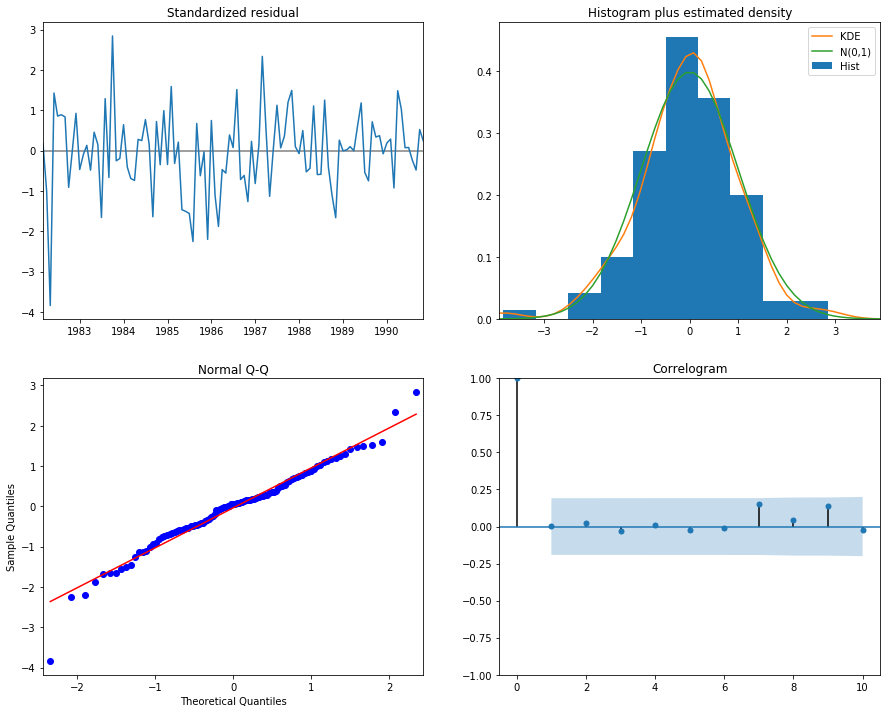

In [51]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

График автокорреляции остатков не визуализирует наличие значимой зависимости между остатками,
критерий Дики-Фулерв это подтверждает.

Мы получили модель с хорошими остатками, модем приступить к построению прогноза

In [52]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                  aver_total_diff12   No. Observations:                  119
Model:             SARIMAX(3, 0, 3)x(0, 1, 1, 14)   Log Likelihood                -767.703
Date:                            Fri, 22 Mar 2019   AIC                           1551.405
Time:                                    22:54:06   BIC                           1572.637
Sample:                                01-01-1981   HQIC                          1560.009
                                     - 11-01-1990                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2721      0.110     -2.481      0.013      -0.487      -0.057
ar.L2          0.1671      0.080      2.082      0.037       0.010       0.324
ar.L3          0.8494      0.120      7.083      0.000       0.614       1.084
ma.L1          0.6400      0.149      4.306      0.000       0.349       0.931
ma.L2          0.1785      0.155      1.151      0.250      -0.125       0.483
ma.L3         -0.3267      0.168     -1.944      0.052      -0.656       0.003
ma.S.L14      -0.9660      1.054     -0.916      0.359      -3.032       1.100
sigma2      1.065e+05   1.07e+05      0.999      0.318   -1.02e+05    3.15e+05
===================================================================================
Ljung-Box (Q):                       48.54   Jarque-Bera (JB):                14.07
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -0.40
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ошибка прогноза модели ARIMA на обучающей части ряда: MAE = 280.0,      MSE = 159817.2


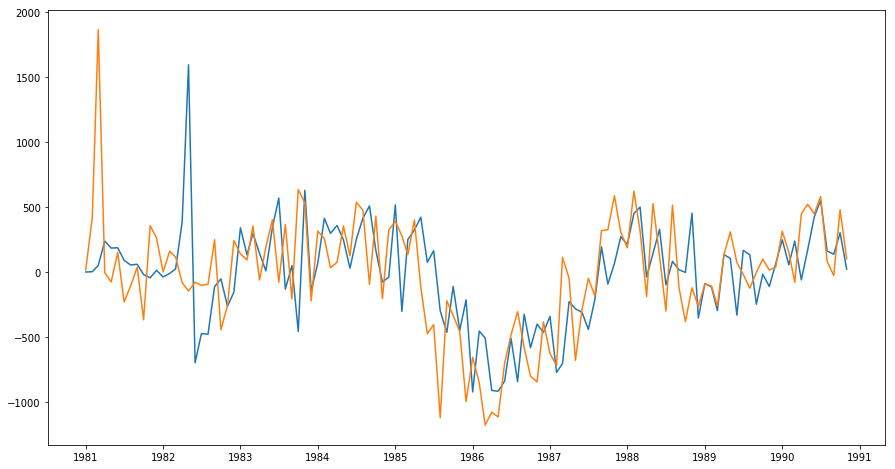

In [53]:
data_for_train['model_ARIMA'] = best_model.fittedvalues
MAE_train_ARIMA = mean_absolute_error(data_for_train.aver_total_diff12,data_for_train['model_ARIMA'])
MSE_train_ARIMA = mean_squared_error(data_for_train.aver_total_diff12,data_for_train['model_ARIMA'])
print(f'Ошибка прогноза модели ARIMA на обучающей части ряда: MAE = {round(MAE_train_ARIMA,2)},\
      MSE = {round(MSE_train_ARIMA,2)}')

plt.plot(data_for_train['model_ARIMA'], label = 'ARIMA')
plt.plot(data_for_train.aver_total_diff12,label = 'actual')

D:\anaconda37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


Ошибка прогноза модели ARIMA на тестовой части ряда: MAE = 307.57, MSE = 168744.73


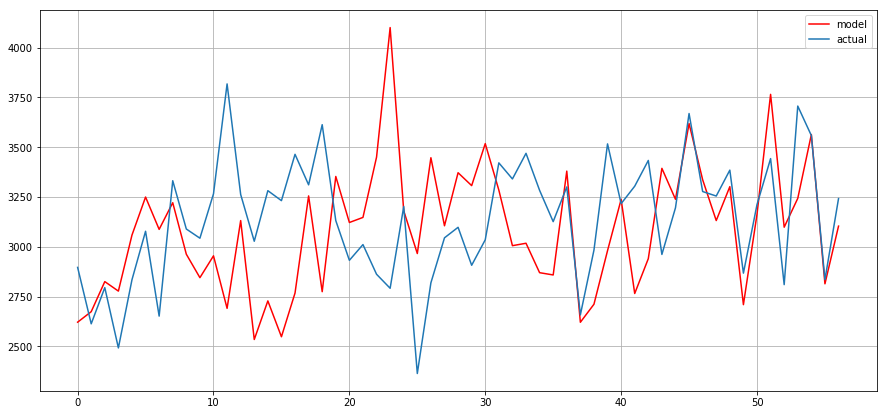

In [54]:
#построим прогноз временного ряда на тестовый период.
#forecast = best_model.get_prediction(pd.to_datetime('1982/01/01', '1995/01/01','M'))
date_list = [datetime.datetime.strptime("1990-12-01", "%Y-%m-%d") + relativedelta(months=x) \
             for x in range(0,len(data_for_test.aver_total))]
actual = data_for_test.aver_total.values

data['ARIMA'] = best_model.predict(start=1, end=188) + data.aver_total.shift(12)

MAE_test_ARIMA = mean_absolute_error(actual,data['ARIMA'][-57:].values)
MSE_test_ARIMA = mean_squared_error(actual,data['ARIMA'][-57:].values)


print(f'Ошибка прогноза модели ARIMA на тестовой части ряда: MAE = {round(MAE_test_ARIMA,2)}, MSE = {round(MSE_test_ARIMA,2)}')

plt.figure(figsize=(15, 7))
plt.plot(data['ARIMA'][-57:].values, color='r', label="model")
plt.plot(actual, label="actual")
plt.legend()
#plt.axvspan(len(actual), len(data['forecast_ARIMA']), alpha=0.5, color='lightgrey')
plt.grid(True)



***ВЫВОД:***
    Ошибка прогноза модели ARIMA на обучающей части ряда: MAE = 280.0,      MSE = 159817.2
    Ошибка прогноза модели ARIMA на тестовой части ряда: MAE = 307.57, MSE = 168744.73     
   

In [55]:
alg.append('ARIMA')
AE_train.append(MAE_train_ARIMA)
SE_train.append(MSE_train_ARIMA)
AE_test.append(MAE_test_ARIMA)
SE_test.append(MSE_test_ARIMA)
t.append('5min 33s')

***4) Сделайте предсказание с помощью fbprophet и измерьте mse и mae предсказания на train и на test***

In [56]:
from fbprophet import Prophet

D:\anaconda37\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
D:\anaconda37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [57]:
data = pd.read_csv('monthly-total-number-of-pigs-sla.csv', index_col = ['Month'])
data = data.dropna()
data.columns = ['Total']

In [58]:
# преобразуем тип индекса Dataframe в datetime
data.index = [datetime.datetime.strptime(i,"%Y-%m") for i in data.index] 
# поскольку количество дней каждого месяца не единое число, выведем среднее значение
# убитых свиней  по каждому месяцу

import calendar

month = [i.month for i in data.index]
year = [i.year for i in data.index]     
data['month'] = month
data['year'] = year

i = 0

# создаем список количетсва дней в месяце года
day_in_month = []                   
while i < data.shape[0]:
    day_in_month.append(calendar.monthrange(data['year'][i], data['month'][i])[1])
    i = i+1

data['day_in_month'] = day_in_month

# создаем отнормированное значение целевой переменной 
data['aver_total'] = data['Total']/data['day_in_month']
del data['Total']
del data['day_in_month']


In [59]:
data['data'] = data.index
di = data.reset_index()
di.rename(columns={'aver_total': 'y', 'data': 'ds'}, inplace=True)
del di['index']
del di['month']
del di['year']


In [60]:
di = di[['ds', 'y']]

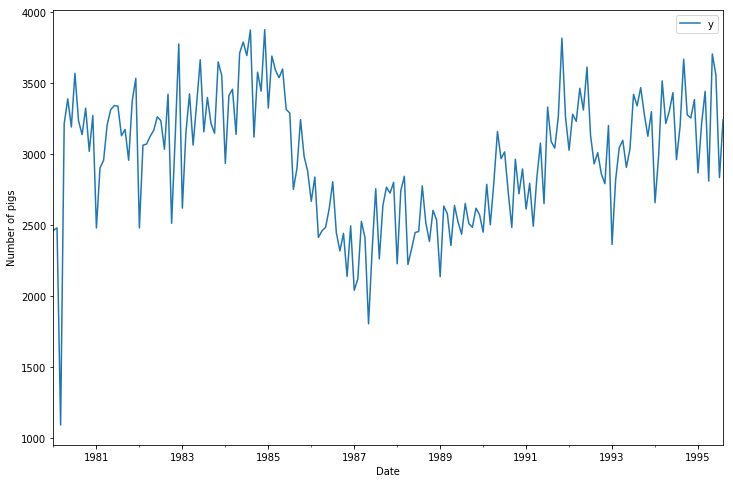

In [61]:
ax = di.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Number of pigs')
ax.set_xlabel('Date')
plt.show()

In [62]:
train = di[:130]
test = di[130:]

In [63]:
%%time
model = Prophet(interval_width=0.95)
model.fit(train)
forecast = model.predict(test)

future = model.make_future_dataframe(periods=58,freq='MS')
forecast = model.predict(future)

prediction = forecast['yhat'][130:]
actual_train = train['y']
actual = test['y']
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(di.set_index('ds'))


D:\anaconda37\lib\site-packages\fbprophet\forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
D:\anaconda37\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Wall time: 4.27 s


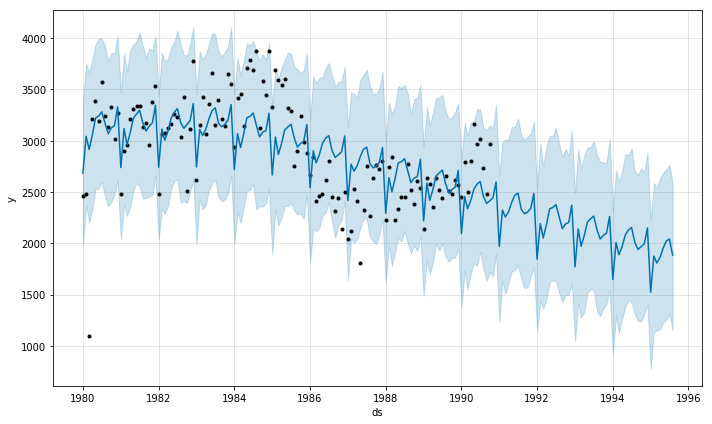

<Figure size 1080x576 with 0 Axes>

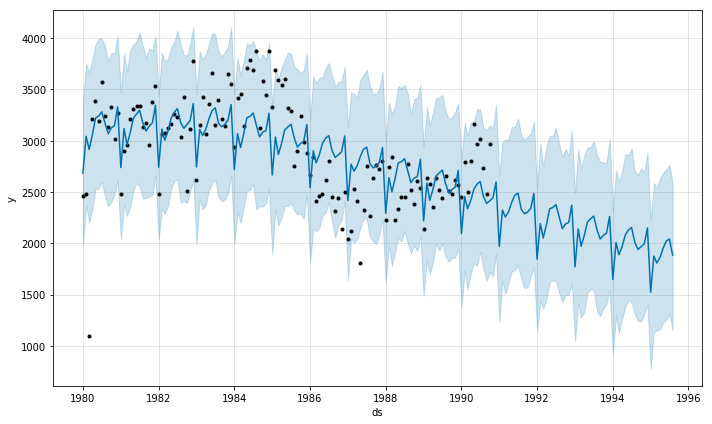

In [64]:
plt.figure(1)
model.plot(forecast)

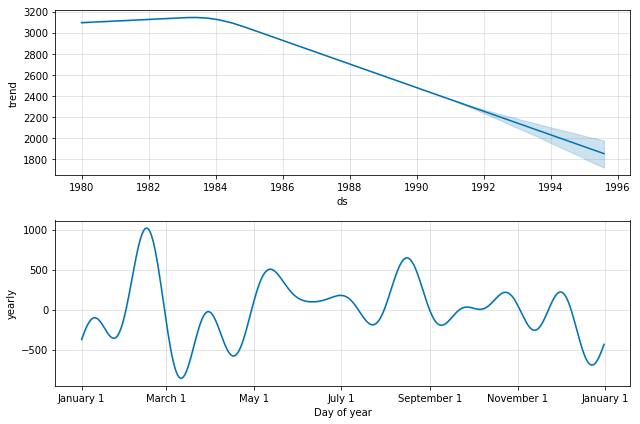

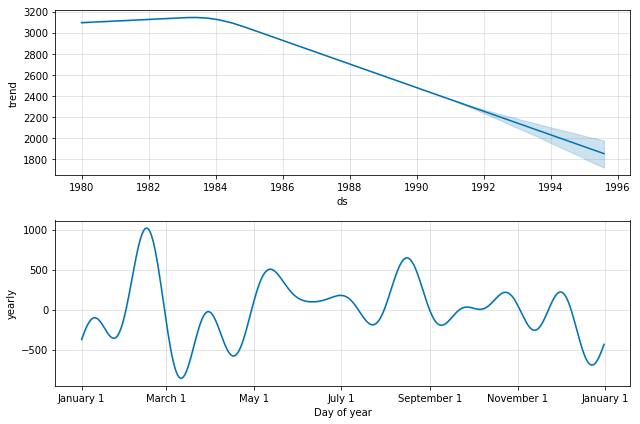

In [65]:
model.plot_components(forecast)

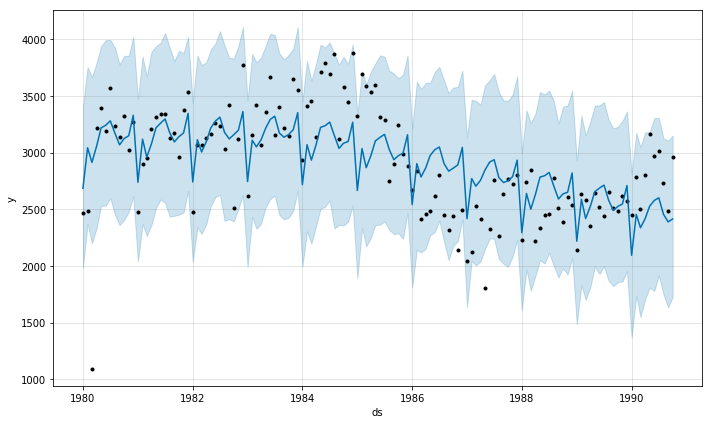

<Figure size 1080x576 with 0 Axes>

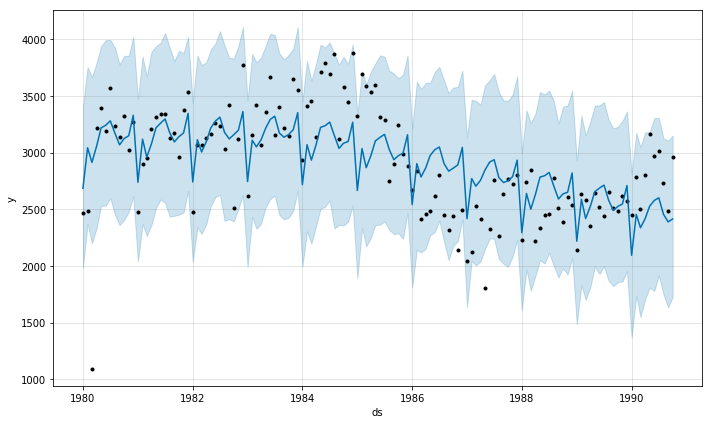

In [66]:
#Визуализация предсказания тестовой части ряда
plt.figure(1)

model.plot(forecast[:130])  

In [67]:
MAE_train = round(mean_absolute_error(actual_train,forecast.yhat[:130]),2)
MSE_train = round(mean_squared_error(actual_train,forecast.yhat[:130]),2)
print(f'Ошибка модели Prophet на обучающей части ряда: MAE = {MAE_train},MSE = {MSE_train}')

MAE_test = round(mean_absolute_error(actual,prediction),2)
MSE_test = round(mean_squared_error(actual,prediction),2)

print(f'Ошибка модели Prophet на тестовой части ряда: MAE = {MAE_test},MSE = {MSE_test}')

Ошибка модели Prophet на обучающей части ряда: MAE = 273.3,MSE = 136129.29
Ошибка модели Prophet на тестовой части ряда: MAE = 996.61,MSE = 1129686.72


***ВЫВОД***
Prophet  показал наихудшие результаты предсказания на тестовой выборке.
Величина ошибка MSE, MAE -  наибольшая.


Среди требований к ряду - он должен иметь аддитивную сезонность. У нас ряд с примерно аддитивной сезонностью.
Почему модель показывает такие плохие данные? Может ли это быть из-за сезонности или это особенность
применения метода на малых рядах (в нашем случае 188 значений)?

In [68]:
alg.append('fbprophet')
AE_train.append(MAE_train)
SE_train.append(MSE_train)
AE_test.append(MAE_test)
SE_test.append(MSE_test)
t.append('4.55 s')

***5) Поработайте над созданием новых признаков (лаги, аггрегированные признаки и т.д.) и примените для предсказания линейную регрессию и какой-нибудь нелинейный алгоритм.***


In [69]:
import pandas as pd
def code_mean(data, cat_feature, target):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[target].mean())

In [70]:
data_ML = pd.DataFrame(data.iloc[:,:3])
data_ML.head()

,month,year,aver_total
1980-01-01,1,1980,2463.806452
1980-02-01,2,1980,2480.931034
1980-03-01,3,1980,1092.677419
1980-04-01,4,1980,3214.266667
1980-05-01,5,1980,3389.806452


In [71]:
def prepareData(data, lag_start, lag_end, test_size):

    data_ML = pd.DataFrame(data.copy())
    
   
    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data_ML)*(1-test_size))
    data['month_decod'] = list(map(code_mean(data[:test_index],'month', 'aver_total').get, data.month))
    del data['month']

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data_ML["lag_{}".format(i)] = data_ML.aver_total.shift(i)

    data_ML = data_ML.dropna()
    data_ML = data_ML.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    y_train = data_ML.loc[:test_index]["aver_total"]
    X_train = data_ML.loc[:test_index].drop(["aver_total"], axis=1)
    y_test = data_ML.loc[test_index:]["aver_total"]
    X_test = data_ML.loc[test_index:].drop(["aver_total"], axis=1)
    
    return X_train, X_test, y_train, y_test

D:\anaconda37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


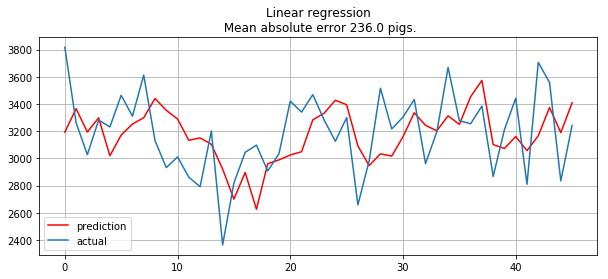

In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train, X_test, y_train, y_test = prepareData(data_ML, test_size=0.3, lag_start=1, lag_end=12)

lr = LinearRegression() 
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(10, 4))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} pigs.".format(round(mean_absolute_error(y_test, prediction))))
plt.grid(True)


In [73]:
def LR_cv(data,cv, test_size):
    folds_train_x = TimeSerCV(data, 3, 0.3)
    folds_train_y = TimeSerCV(data, 3, 0.3)
    MSE_test_LR  = []
    MAE_test_LR  = []
    i = 0
    while i <len(folds_train_x):
        lr.fit(folds_train_x[i],folds_train_y[i])
        MSE_test = mean_squared_error(folds_train_y[i+1],lr.predict(folds_train_x[i+1]))
        MAE_test = mean_absolute_error(folds_train_y[i+1],lr.predict(folds_train_x[i+1]))
        
        MSE_test_LR.append(MSE_test)
        MAE_test_LR.append(MAE_test)
        i = i+2
    MSE_test_LR = mean(MSE_test_LR)
    MAE_test_LR = mean(MAE_test_LR)
    return [MAE_test_LR, MSE_test_LR]

In [74]:
train_error = LR_cv(X_train,3,0.3)
train_error

[5.595649147098659e-13, 6.764851315794828e-25]

In [75]:
%%time
lr.fit(X_train,y_train)
prediction_test = lr.predict(X_test)

MAE_train = round(train_error[0],2)
MSE_train = round(train_error[1],2)

MAE_test  = mean_absolute_error(y_test,prediction_test)
MSE_test  = mean_squared_error(y_test,prediction_test)

print(f'Величина ошибки LR на обучающей части ряда: MAE = {MAE_train}, MSE = {MSE_train}')
print(f'Величина ошибки LR на тестовой части ряда: MAE = {round(MAE_test,2)}, MSE = {round(MSE_test,2)}')

Величина ошибки LR на обучающей части ряда: MAE = 0.0, MSE = 0.0
Величина ошибки LR на тестовой части ряда: MAE = 235.65, MSE = 79215.26
Wall time: 3.97 ms


***ВЫВОД по Линейной регрессии:***
Генерирование новых признаков и применение метода линейной регрессии позволило существенно улучшить результат и 
сделать его наиболее адекватным.

In [76]:
alg.append('LR')
AE_train.append(MAE_train)
SE_train.append(MSE_train)
AE_test.append(MAE_test)
SE_test.append(MSE_test)
t.append('7.98 ms')

In [77]:
X_train.shape

(132, 13)

In [78]:
%%time
parametres = {'n_estimators': [50,70,90,120],
             'min_samples_leaf':[5,10,15,25,35]
             }

grid = GridSearchCV(RandomForestRegressor(), parametres, cv = 5).fit(X_train, y_train)
pred_RF_train = grid.predict(X_train)
MAE_train  = round(mean_absolute_error(y_train,pred_RF_train),2)
MSE_train  = round(mean_squared_error(y_train,pred_RF_train),2)

pred_RF_test = grid.predict(X_test)
MAE_test  = round(mean_absolute_error(y_test,pred_RF_test),2)
MSE_test  = round(mean_squared_error(y_test,pred_RF_test),2)
print(f'Величина ошибки LR на обучающей части ряда: MAE = {MAE_train}, MSE = {MSE_train}')
print(f'Величина ошибки LR на тестовой части ряда: MAE = {MAE_test}, MSE = {MSE_test}')

Величина ошибки LR на обучающей части ряда: MAE = 182.32, MSE = 55680.1
Величина ошибки LR на тестовой части ряда: MAE = 230.24, MSE = 80241.77
Wall time: 6.9 s


D:\anaconda37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [79]:
alg.append('RF')
AE_train.append(MAE_train)
SE_train.append(MSE_train)
AE_test.append(MAE_test)
SE_test.append(MSE_test)
t.append('6.75 s')

In [80]:
# заполняем Dataframe  с результатами алгоритмов
total['algorithm'] = alg
total['MAE_train'] = AE_train
total['MSE_train'] = SE_train
total['MAE_test'] = AE_test
total['MSE_test'] = SE_test
total['time'] = t

total

,algorithm,MAE_train,MSE_train,MAE_test,MSE_test,time
0,double_exponential_smoothing,29.960000,1493.470000,341.370000,1.663658e+05,704 ms
1,triple_exponential_smoothing,41.420000,3085.280000,351.970000,1.815710e+05,1.64 s
2,ARMA,251.700000,112015.230000,316.490000,1.546190e+05,6.51 s
3,ARIMA,280.000375,159817.195901,307.568470,1.687447e+05,5min 33s
4,fbprophet,273.300000,136129.290000,996.610000,1.129687e+06,4.55 s
5,LR,0.000000,0.000000,235.645437,7.921526e+04,7.98 ms
6,RF,182.320000,55680.100000,230.240000,8.024177e+04,6.75 s


 ВЫВОД: Наилучшее предсказание показывают алгоритмы, обученные на дополнительно сгенерированных лаговых признаках:
 линейная регрессия и случайный лес.
 Попробуем получить алгоритм, с лучшими показателями

In [82]:
prediction = pd.DataFrame(y_test)
prediction['lr'] = prediction_test
prediction['RF'] = pred_RF_test
prediction['ensenble'] = (prediction['lr'] + prediction['RF'])/2

MAE_ensemble = mean_absolute_error(y_test,prediction['ensenble'])
MSE_ensemble = mean_squared_error(y_test,prediction['ensenble'])
print(f'Величина ошибки ensemble на тестовой части ряда: MAE = {round(MAE_ensemble,2)}, MSE = {round(MSE_ensemble,2)}')

Величина ошибки ensemble на тестовой части ряда: MAE = 222.7, MSE = 75752.68


В результате усреднения ответов лучших алгоритмов нам удалось улучшить результат